In [1]:
import sys
sys.path.append(r'../HelperFunctions')
import DataHelper as dh
import AugHelper as ah
import ModelConfigHelper as mch

In [2]:
path_info = dh.getFileDirectory()
path_info

Please enter the root directory of the file path -> C:\Users\user\Desktop\ML\PyTorch\Hackathon\RiceLeaf\Dataset\Rice Leaf Disease Images\Rice Leaf Disease Images


{'path': 'C:\\Users\\user\\Desktop\\ML\\PyTorch\\Hackathon\\RiceLeaf\\Dataset\\Rice Leaf Disease Images\\Rice Leaf Disease Images',
 'type': 'folder'}

In [3]:
dh.showFileCount(pathInfo=path_info)

Bacterialblight :-
1584
Blast :-
1440
Brownspot :-
1600
Tungro :-
1308


In [4]:
df = dh.getDataFrame(pathInfo=path_info)
df.info()
df.dtypes
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5932 entries, 0 to 5931
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   imgPath       5932 non-null   object  
 1   label         5932 non-null   category
 2   augmentation  5932 non-null   object  
dtypes: category(1), object(2)
memory usage: 98.8+ KB


,imgPath,label,augmentation
0,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Brownspot,normal
1,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Brownspot,normal
2,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Tungro,normal
3,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Brownspot,normal
4,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Blast,normal
...,...,...,...
5927,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Brownspot,normal
5928,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Bacterialblight,normal
5929,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Blast,normal
5930,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,Blast,normal


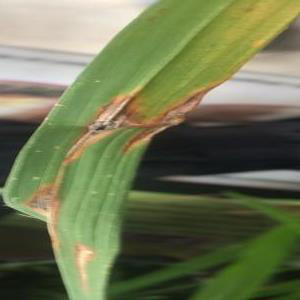

In [5]:
from PIL import Image
img = Image.open(df.iloc[5,0])
img

In [6]:
dictlabels=dh.getLabelDicts(df=df)
dictlabels

Index(['Bacterialblight', 'Blast', 'Brownspot', 'Tungro'], dtype='object')

In [7]:
df = dh.dfPreProcess(df=df)
df.info()
df.dtypes
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5932 entries, 0 to 5931
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   imgPath       5932 non-null   object
 1   augmentation  5932 non-null   object
 2   ylabel        5932 non-null   int8  
dtypes: int8(1), object(2)
memory usage: 98.6+ KB


,imgPath,augmentation,ylabel
0,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,2
1,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,2
2,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,3
3,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,2
4,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,1
...,...,...,...
5927,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,2
5928,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,0
5929,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,1
5930,C:\Users\user\Desktop\ML\PyTorch\Hackathon\Ric...,normal,1


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val = train_test_split(df,test_size=0.2)

In [9]:
augDict = ah.getAugmentation(augmentRequired=True,augmentPolicies=[ah.transforms.AutoAugmentPolicy.IMAGENET])
augDict

{'hFlip': RandomHorizontalFlip(p=1),
 'vFlip': RandomVerticalFlip(p=1),
 'rot': RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0),
 'aug0': AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)}

In [10]:
imgTransform = ah.getImageTransform(227)
imgTransform

Compose(
    Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [11]:
X_train = ah.augmentDataFrame(df=X_train,augDict=augDict)
X_train
X_train['augmentation'].unique()

array(['aug0', 'rot', 'vFlip', 'hFlip', 'normal'], dtype=object)

In [12]:
X_val
X_val['augmentation'].unique()

array(['normal'], dtype=object)

In [13]:
train_ds  = ah.KroniaDataset(data=X_train,transforms=imgTransform)
val_ds = ah.KroniaDataset(data=X_train,transforms=imgTransform)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [15]:
train_dl = DataLoader(dataset=train_ds,batch_size=64,shuffle=True)
val_dl = DataLoader(dataset=val_ds,batch_size=64,shuffle=True)

In [16]:
torch.manual_seed(42)
model = mch.getCustomizedPreTrainedModel('alexnet',final_node_count=len(dictlabels),feature_extract=True,preTrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
train_loss,val_loss = mch.trainModel(model=model,train_dl=train_dl,val_dl=val_dl,criterion=criterion,optim=optimizer,train_samples=len(X_train),batch_size=64,soft_max=True,epochs=10)

============= New Epoch =========================
epoch:  0  batch:    2 [   128/23725]  loss: 1.29838157      accuracy:  38.281%
epoch:  0  batch:    4 [   256/23725]  loss: 0.88312811      accuracy:  51.562%
epoch:  0  batch:    6 [   384/23725]  loss: 0.79559809      accuracy:  56.510%
epoch:  0  batch:    8 [   512/23725]  loss: 0.50492090      accuracy:  61.328%
epoch:  0  batch:   10 [   640/23725]  loss: 0.46445391      accuracy:  66.406%
epoch:  0  batch:   12 [   768/23725]  loss: 0.45753193      accuracy:  69.010%
epoch:  0  batch:   14 [   896/23725]  loss: 0.37966716      accuracy:  71.429%
epoch:  0  batch:   16 [  1024/23725]  loss: 0.33158118      accuracy:  72.656%
epoch:  0  batch:   18 [  1152/23725]  loss: 0.49226150      accuracy:  73.611%
epoch:  0  batch:   20 [  1280/23725]  loss: 0.49981102      accuracy:  74.297%
epoch:  0  batch:   22 [  1408/23725]  loss: 0.18437266      accuracy:  75.639%
epoch:  0  batch:   24 [  1536/23725]  loss: 0.37852204      accuracy:

epoch:  0  batch:  206 [ 13184/23725]  loss: 0.10858358      accuracy:  91.975%
epoch:  0  batch:  208 [ 13312/23725]  loss: 0.06701280      accuracy:  92.030%
epoch:  0  batch:  210 [ 13440/23725]  loss: 0.08183405      accuracy:  92.046%
epoch:  0  batch:  212 [ 13568/23725]  loss: 0.12734421      accuracy:  92.084%
epoch:  0  batch:  214 [ 13696/23725]  loss: 0.11777669      accuracy:  92.107%
epoch:  0  batch:  216 [ 13824/23725]  loss: 0.07483590      accuracy:  92.151%
epoch:  0  batch:  218 [ 13952/23725]  loss: 0.09494562      accuracy:  92.195%
epoch:  0  batch:  220 [ 14080/23725]  loss: 0.15871386      accuracy:  92.209%
epoch:  0  batch:  222 [ 14208/23725]  loss: 0.05085966      accuracy:  92.279%
epoch:  0  batch:  224 [ 14336/23725]  loss: 0.12949790      accuracy:  92.320%
epoch:  0  batch:  226 [ 14464/23725]  loss: 0.09098904      accuracy:  92.360%
epoch:  0  batch:  228 [ 14592/23725]  loss: 0.08155895      accuracy:  92.407%
epoch:  0  batch:  230 [ 14720/23725]  l

epoch:  1  batch:   40 [  2560/23725]  loss: 0.07179631      accuracy:  97.617%
epoch:  1  batch:   42 [  2688/23725]  loss: 0.06038853      accuracy:  97.656%
epoch:  1  batch:   44 [  2816/23725]  loss: 0.06709514      accuracy:  97.692%
epoch:  1  batch:   46 [  2944/23725]  loss: 0.03143268      accuracy:  97.758%
epoch:  1  batch:   48 [  3072/23725]  loss: 0.05684257      accuracy:  97.786%
epoch:  1  batch:   50 [  3200/23725]  loss: 0.04292240      accuracy:  97.875%
epoch:  1  batch:   52 [  3328/23725]  loss: 0.08824630      accuracy:  97.867%
epoch:  1  batch:   54 [  3456/23725]  loss: 0.04299811      accuracy:  97.917%
epoch:  1  batch:   56 [  3584/23725]  loss: 0.07473335      accuracy:  97.907%
epoch:  1  batch:   58 [  3712/23725]  loss: 0.10323963      accuracy:  97.899%
epoch:  1  batch:   60 [  3840/23725]  loss: 0.06503552      accuracy:  97.917%
epoch:  1  batch:   62 [  3968/23725]  loss: 0.03796137      accuracy:  97.908%
epoch:  1  batch:   64 [  4096/23725]  l

epoch:  1  batch:  246 [ 15744/23725]  loss: 0.05941476      accuracy:  98.260%
epoch:  1  batch:  248 [ 15872/23725]  loss: 0.03658894      accuracy:  98.274%
epoch:  1  batch:  250 [ 16000/23725]  loss: 0.04231131      accuracy:  98.287%
epoch:  1  batch:  252 [ 16128/23725]  loss: 0.10866757      accuracy:  98.282%
epoch:  1  batch:  254 [ 16256/23725]  loss: 0.03367777      accuracy:  98.284%
epoch:  1  batch:  256 [ 16384/23725]  loss: 0.03414274      accuracy:  98.285%
epoch:  1  batch:  258 [ 16512/23725]  loss: 0.10492502      accuracy:  98.274%
epoch:  1  batch:  260 [ 16640/23725]  loss: 0.03491038      accuracy:  98.275%
epoch:  1  batch:  262 [ 16768/23725]  loss: 0.02045958      accuracy:  98.282%
epoch:  1  batch:  264 [ 16896/23725]  loss: 0.06481139      accuracy:  98.290%
epoch:  1  batch:  266 [ 17024/23725]  loss: 0.07852149      accuracy:  98.285%
epoch:  1  batch:  268 [ 17152/23725]  loss: 0.02964993      accuracy:  98.292%
epoch:  1  batch:  270 [ 17280/23725]  l

epoch:  2  batch:   80 [  5120/23725]  loss: 0.05841679      accuracy:  99.121%
epoch:  2  batch:   82 [  5248/23725]  loss: 0.02201854      accuracy:  99.123%
epoch:  2  batch:   84 [  5376/23725]  loss: 0.05907933      accuracy:  99.070%
epoch:  2  batch:   86 [  5504/23725]  loss: 0.03937342      accuracy:  99.019%
epoch:  2  batch:   88 [  5632/23725]  loss: 0.09209273      accuracy:  98.970%
epoch:  2  batch:   90 [  5760/23725]  loss: 0.08159249      accuracy:  98.941%
epoch:  2  batch:   92 [  5888/23725]  loss: 0.02937777      accuracy:  98.947%
epoch:  2  batch:   94 [  6016/23725]  loss: 0.03207286      accuracy:  98.969%
epoch:  2  batch:   96 [  6144/23725]  loss: 0.06214116      accuracy:  98.958%
epoch:  2  batch:   98 [  6272/23725]  loss: 0.09250554      accuracy:  98.932%
epoch:  2  batch:  100 [  6400/23725]  loss: 0.06100162      accuracy:  98.938%
epoch:  2  batch:  102 [  6528/23725]  loss: 0.03868036      accuracy:  98.958%
epoch:  2  batch:  104 [  6656/23725]  l

epoch:  2  batch:  286 [ 18304/23725]  loss: 0.02836936      accuracy:  98.885%
epoch:  2  batch:  288 [ 18432/23725]  loss: 0.07380670      accuracy:  98.888%
epoch:  2  batch:  290 [ 18560/23725]  loss: 0.02330022      accuracy:  98.895%
epoch:  2  batch:  292 [ 18688/23725]  loss: 0.03705084      accuracy:  98.898%
epoch:  2  batch:  294 [ 18816/23725]  loss: 0.06022649      accuracy:  98.900%
epoch:  2  batch:  296 [ 18944/23725]  loss: 0.04363963      accuracy:  98.897%
epoch:  2  batch:  298 [ 19072/23725]  loss: 0.02252115      accuracy:  98.899%
epoch:  2  batch:  300 [ 19200/23725]  loss: 0.06330623      accuracy:  98.896%
epoch:  2  batch:  302 [ 19328/23725]  loss: 0.02746631      accuracy:  98.903%
epoch:  2  batch:  304 [ 19456/23725]  loss: 0.04559631      accuracy:  98.900%
epoch:  2  batch:  306 [ 19584/23725]  loss: 0.01387003      accuracy:  98.902%
epoch:  2  batch:  308 [ 19712/23725]  loss: 0.02615332      accuracy:  98.899%
epoch:  2  batch:  310 [ 19840/23725]  l

epoch:  3  batch:  120 [  7680/23725]  loss: 0.01382762      accuracy:  98.763%
epoch:  3  batch:  122 [  7808/23725]  loss: 0.00589877      accuracy:  98.770%
epoch:  3  batch:  124 [  7936/23725]  loss: 0.05602595      accuracy:  98.753%
epoch:  3  batch:  126 [  8064/23725]  loss: 0.02610976      accuracy:  98.748%
epoch:  3  batch:  128 [  8192/23725]  loss: 0.02176119      accuracy:  98.743%
epoch:  3  batch:  130 [  8320/23725]  loss: 0.01621187      accuracy:  98.762%
epoch:  3  batch:  132 [  8448/23725]  loss: 0.05229847      accuracy:  98.769%
epoch:  3  batch:  134 [  8576/23725]  loss: 0.01607300      accuracy:  98.787%
epoch:  3  batch:  136 [  8704/23725]  loss: 0.04009703      accuracy:  98.794%
epoch:  3  batch:  138 [  8832/23725]  loss: 0.04987295      accuracy:  98.788%
epoch:  3  batch:  140 [  8960/23725]  loss: 0.03152983      accuracy:  98.783%
epoch:  3  batch:  142 [  9088/23725]  loss: 0.03349297      accuracy:  98.790%
epoch:  3  batch:  144 [  9216/23725]  l

epoch:  3  batch:  326 [ 20864/23725]  loss: 0.07401659      accuracy:  98.965%
epoch:  3  batch:  328 [ 20992/23725]  loss: 0.01341190      accuracy:  98.966%
epoch:  3  batch:  330 [ 21120/23725]  loss: 0.03108134      accuracy:  98.963%
epoch:  3  batch:  332 [ 21248/23725]  loss: 0.01211453      accuracy:  98.969%
epoch:  3  batch:  334 [ 21376/23725]  loss: 0.03408694      accuracy:  98.966%
epoch:  3  batch:  336 [ 21504/23725]  loss: 0.02111397      accuracy:  98.963%
epoch:  3  batch:  338 [ 21632/23725]  loss: 0.01821722      accuracy:  98.964%
epoch:  3  batch:  340 [ 21760/23725]  loss: 0.01139728      accuracy:  98.971%
epoch:  3  batch:  342 [ 21888/23725]  loss: 0.04514117      accuracy:  98.967%
epoch:  3  batch:  344 [ 22016/23725]  loss: 0.02664929      accuracy:  98.964%
epoch:  3  batch:  346 [ 22144/23725]  loss: 0.00852703      accuracy:  98.966%
epoch:  3  batch:  348 [ 22272/23725]  loss: 0.00511177      accuracy:  98.972%
epoch:  3  batch:  350 [ 22400/23725]  l

epoch:  4  batch:  160 [ 10240/23725]  loss: 0.01927490      accuracy:  99.209%
epoch:  4  batch:  162 [ 10368/23725]  loss: 0.02132651      accuracy:  99.219%
epoch:  4  batch:  164 [ 10496/23725]  loss: 0.05471666      accuracy:  99.209%
epoch:  4  batch:  166 [ 10624/23725]  loss: 0.02663722      accuracy:  99.219%
epoch:  4  batch:  168 [ 10752/23725]  loss: 0.01325662      accuracy:  99.228%
epoch:  4  batch:  170 [ 10880/23725]  loss: 0.04728970      accuracy:  99.237%
epoch:  4  batch:  172 [ 11008/23725]  loss: 0.00659663      accuracy:  99.246%
epoch:  4  batch:  174 [ 11136/23725]  loss: 0.01174390      accuracy:  99.255%
epoch:  4  batch:  176 [ 11264/23725]  loss: 0.00561668      accuracy:  99.254%
epoch:  4  batch:  178 [ 11392/23725]  loss: 0.00564546      accuracy:  99.263%
epoch:  4  batch:  180 [ 11520/23725]  loss: 0.01942241      accuracy:  99.271%
epoch:  4  batch:  182 [ 11648/23725]  loss: 0.02290527      accuracy:  99.279%
epoch:  4  batch:  184 [ 11776/23725]  l

epoch:  4  batch:  366 [ 23424/23725]  loss: 0.04906590      accuracy:  99.121%
epoch:  4  batch:  368 [ 23552/23725]  loss: 0.03237397      accuracy:  99.117%
epoch:  4  batch:  370 [ 23680/23725]  loss: 0.02275566      accuracy:  99.122%
============= New Epoch =========================
epoch:  5  batch:    2 [   128/23725]  loss: 0.01360894      accuracy:  99.219%
epoch:  5  batch:    4 [   256/23725]  loss: 0.03939869      accuracy:  99.219%
epoch:  5  batch:    6 [   384/23725]  loss: 0.00289880      accuracy:  99.479%
epoch:  5  batch:    8 [   512/23725]  loss: 0.06183733      accuracy:  99.219%
epoch:  5  batch:   10 [   640/23725]  loss: 0.01351946      accuracy:  99.219%
epoch:  5  batch:   12 [   768/23725]  loss: 0.02186820      accuracy:  99.349%
epoch:  5  batch:   14 [   896/23725]  loss: 0.02083053      accuracy:  99.219%
epoch:  5  batch:   16 [  1024/23725]  loss: 0.07350705      accuracy:  99.023%
epoch:  5  batch:   18 [  1152/23725]  loss: 0.03877054      accuracy:

epoch:  5  batch:  200 [ 12800/23725]  loss: 0.05991668      accuracy:  99.188%
epoch:  5  batch:  202 [ 12928/23725]  loss: 0.00324925      accuracy:  99.196%
epoch:  5  batch:  204 [ 13056/23725]  loss: 0.01928614      accuracy:  99.203%
epoch:  5  batch:  206 [ 13184/23725]  loss: 0.00519268      accuracy:  99.204%
epoch:  5  batch:  208 [ 13312/23725]  loss: 0.00563749      accuracy:  99.204%
epoch:  5  batch:  210 [ 13440/23725]  loss: 0.02279139      accuracy:  99.204%
epoch:  5  batch:  212 [ 13568/23725]  loss: 0.01473857      accuracy:  99.211%
epoch:  5  batch:  214 [ 13696/23725]  loss: 0.02361240      accuracy:  99.211%
epoch:  5  batch:  216 [ 13824/23725]  loss: 0.00770040      accuracy:  99.219%
epoch:  5  batch:  218 [ 13952/23725]  loss: 0.04409910      accuracy:  99.219%
epoch:  5  batch:  220 [ 14080/23725]  loss: 0.03580131      accuracy:  99.212%
epoch:  5  batch:  222 [ 14208/23725]  loss: 0.01995937      accuracy:  99.205%
epoch:  5  batch:  224 [ 14336/23725]  l

epoch:  6  batch:   34 [  2176/23725]  loss: 0.01695891      accuracy:  99.173%
epoch:  6  batch:   36 [  2304/23725]  loss: 0.01905049      accuracy:  99.219%
epoch:  6  batch:   38 [  2432/23725]  loss: 0.02650348      accuracy:  99.219%
epoch:  6  batch:   40 [  2560/23725]  loss: 0.00978906      accuracy:  99.219%
epoch:  6  batch:   42 [  2688/23725]  loss: 0.00371008      accuracy:  99.219%
epoch:  6  batch:   44 [  2816/23725]  loss: 0.00459854      accuracy:  99.183%
epoch:  6  batch:   46 [  2944/23725]  loss: 0.00852538      accuracy:  99.185%
epoch:  6  batch:   48 [  3072/23725]  loss: 0.01803959      accuracy:  99.219%
epoch:  6  batch:   50 [  3200/23725]  loss: 0.00908762      accuracy:  99.250%
epoch:  6  batch:   52 [  3328/23725]  loss: 0.00831657      accuracy:  99.279%
epoch:  6  batch:   54 [  3456/23725]  loss: 0.00985314      accuracy:  99.277%
epoch:  6  batch:   56 [  3584/23725]  loss: 0.01850661      accuracy:  99.275%
epoch:  6  batch:   58 [  3712/23725]  l

epoch:  6  batch:  240 [ 15360/23725]  loss: 0.01478653      accuracy:  99.368%
epoch:  6  batch:  242 [ 15488/23725]  loss: 0.01675764      accuracy:  99.374%
epoch:  6  batch:  244 [ 15616/23725]  loss: 0.00402709      accuracy:  99.379%
epoch:  6  batch:  246 [ 15744/23725]  loss: 0.03571753      accuracy:  99.371%
epoch:  6  batch:  248 [ 15872/23725]  loss: 0.02226868      accuracy:  99.376%
epoch:  6  batch:  250 [ 16000/23725]  loss: 0.01932797      accuracy:  99.381%
epoch:  6  batch:  252 [ 16128/23725]  loss: 0.07911829      accuracy:  99.374%
epoch:  6  batch:  254 [ 16256/23725]  loss: 0.00939805      accuracy:  99.379%
epoch:  6  batch:  256 [ 16384/23725]  loss: 0.01556579      accuracy:  99.384%
epoch:  6  batch:  258 [ 16512/23725]  loss: 0.01317707      accuracy:  99.388%
epoch:  6  batch:  260 [ 16640/23725]  loss: 0.00435936      accuracy:  99.381%
epoch:  6  batch:  262 [ 16768/23725]  loss: 0.02262535      accuracy:  99.380%
epoch:  6  batch:  264 [ 16896/23725]  l

epoch:  7  batch:   74 [  4736/23725]  loss: 0.01303677      accuracy:  99.219%
epoch:  7  batch:   76 [  4864/23725]  loss: 0.00387157      accuracy:  99.219%
epoch:  7  batch:   78 [  4992/23725]  loss: 0.01056385      accuracy:  99.239%
epoch:  7  batch:   80 [  5120/23725]  loss: 0.05159374      accuracy:  99.238%
epoch:  7  batch:   82 [  5248/23725]  loss: 0.01574641      accuracy:  99.238%
epoch:  7  batch:   84 [  5376/23725]  loss: 0.00951427      accuracy:  99.256%
epoch:  7  batch:   86 [  5504/23725]  loss: 0.02644927      accuracy:  99.255%
epoch:  7  batch:   88 [  5632/23725]  loss: 0.05528210      accuracy:  99.219%
epoch:  7  batch:   90 [  5760/23725]  loss: 0.03126700      accuracy:  99.201%
epoch:  7  batch:   92 [  5888/23725]  loss: 0.03379679      accuracy:  99.202%
epoch:  7  batch:   94 [  6016/23725]  loss: 0.00150791      accuracy:  99.202%
epoch:  7  batch:   96 [  6144/23725]  loss: 0.01721152      accuracy:  99.202%
epoch:  7  batch:   98 [  6272/23725]  l

epoch:  7  batch:  280 [ 17920/23725]  loss: 0.02914757      accuracy:  99.319%
epoch:  7  batch:  282 [ 18048/23725]  loss: 0.01393519      accuracy:  99.324%
epoch:  7  batch:  284 [ 18176/23725]  loss: 0.00448008      accuracy:  99.318%
epoch:  7  batch:  286 [ 18304/23725]  loss: 0.01959802      accuracy:  99.323%
epoch:  7  batch:  288 [ 18432/23725]  loss: 0.01271728      accuracy:  99.316%
epoch:  7  batch:  290 [ 18560/23725]  loss: 0.07881426      accuracy:  99.310%
epoch:  7  batch:  292 [ 18688/23725]  loss: 0.00331453      accuracy:  99.310%
epoch:  7  batch:  294 [ 18816/23725]  loss: 0.02067841      accuracy:  99.309%
epoch:  7  batch:  296 [ 18944/23725]  loss: 0.10942183      accuracy:  99.298%
epoch:  7  batch:  298 [ 19072/23725]  loss: 0.01465033      accuracy:  99.303%
epoch:  7  batch:  300 [ 19200/23725]  loss: 0.01968940      accuracy:  99.307%
epoch:  7  batch:  302 [ 19328/23725]  loss: 0.07015224      accuracy:  99.296%
epoch:  7  batch:  304 [ 19456/23725]  l

epoch:  8  batch:  114 [  7296/23725]  loss: 0.02624577      accuracy:  99.356%
epoch:  8  batch:  116 [  7424/23725]  loss: 0.02245217      accuracy:  99.353%
epoch:  8  batch:  118 [  7552/23725]  loss: 0.02019588      accuracy:  99.351%
epoch:  8  batch:  120 [  7680/23725]  loss: 0.00885636      accuracy:  99.349%
epoch:  8  batch:  122 [  7808/23725]  loss: 0.01504390      accuracy:  99.360%
epoch:  8  batch:  124 [  7936/23725]  loss: 0.01151822      accuracy:  99.370%
epoch:  8  batch:  126 [  8064/23725]  loss: 0.00684202      accuracy:  99.368%
epoch:  8  batch:  128 [  8192/23725]  loss: 0.01349435      accuracy:  99.377%
epoch:  8  batch:  130 [  8320/23725]  loss: 0.00822178      accuracy:  99.375%
epoch:  8  batch:  132 [  8448/23725]  loss: 0.01402453      accuracy:  99.373%
epoch:  8  batch:  134 [  8576/23725]  loss: 0.02612189      accuracy:  99.370%
epoch:  8  batch:  136 [  8704/23725]  loss: 0.04670575      accuracy:  99.357%
epoch:  8  batch:  138 [  8832/23725]  l

epoch:  8  batch:  320 [ 20480/23725]  loss: 0.01604614      accuracy:  99.316%
epoch:  8  batch:  322 [ 20608/23725]  loss: 0.00267573      accuracy:  99.316%
epoch:  8  batch:  324 [ 20736/23725]  loss: 0.06806008      accuracy:  99.310%
epoch:  8  batch:  326 [ 20864/23725]  loss: 0.00277695      accuracy:  99.310%
epoch:  8  batch:  328 [ 20992/23725]  loss: 0.00914025      accuracy:  99.309%
epoch:  8  batch:  330 [ 21120/23725]  loss: 0.00872524      accuracy:  99.309%
epoch:  8  batch:  332 [ 21248/23725]  loss: 0.02727790      accuracy:  99.308%
epoch:  8  batch:  334 [ 21376/23725]  loss: 0.00410809      accuracy:  99.298%
epoch:  8  batch:  336 [ 21504/23725]  loss: 0.00862890      accuracy:  99.298%
epoch:  8  batch:  338 [ 21632/23725]  loss: 0.02503769      accuracy:  99.293%
epoch:  8  batch:  340 [ 21760/23725]  loss: 0.00938107      accuracy:  99.292%
epoch:  8  batch:  342 [ 21888/23725]  loss: 0.03078391      accuracy:  99.274%
epoch:  8  batch:  344 [ 22016/23725]  l

epoch:  9  batch:  154 [  9856/23725]  loss: 0.01625465      accuracy:  99.178%
epoch:  9  batch:  156 [  9984/23725]  loss: 0.00996996      accuracy:  99.189%
epoch:  9  batch:  158 [ 10112/23725]  loss: 0.00925746      accuracy:  99.179%
epoch:  9  batch:  160 [ 10240/23725]  loss: 0.00806191      accuracy:  99.189%
epoch:  9  batch:  162 [ 10368/23725]  loss: 0.05646946      accuracy:  99.171%
epoch:  9  batch:  164 [ 10496/23725]  loss: 0.00758206      accuracy:  99.181%
epoch:  9  batch:  166 [ 10624/23725]  loss: 0.06758919      accuracy:  99.172%
epoch:  9  batch:  168 [ 10752/23725]  loss: 0.01968474      accuracy:  99.172%
epoch:  9  batch:  170 [ 10880/23725]  loss: 0.05115794      accuracy:  99.164%
epoch:  9  batch:  172 [ 11008/23725]  loss: 0.00248271      accuracy:  99.164%
epoch:  9  batch:  174 [ 11136/23725]  loss: 0.05618672      accuracy:  99.156%
epoch:  9  batch:  176 [ 11264/23725]  loss: 0.00639726      accuracy:  99.148%
epoch:  9  batch:  178 [ 11392/23725]  l

epoch:  9  batch:  360 [ 23040/23725]  loss: 0.04011880      accuracy:  99.123%
epoch:  9  batch:  362 [ 23168/23725]  loss: 0.01064831      accuracy:  99.124%
epoch:  9  batch:  364 [ 23296/23725]  loss: 0.00401525      accuracy:  99.129%
epoch:  9  batch:  366 [ 23424/23725]  loss: 0.00469230      accuracy:  99.129%
epoch:  9  batch:  368 [ 23552/23725]  loss: 0.00492479      accuracy:  99.134%
epoch:  9  batch:  370 [ 23680/23725]  loss: 0.01684999      accuracy:  99.134%

Duration: 5344 seconds


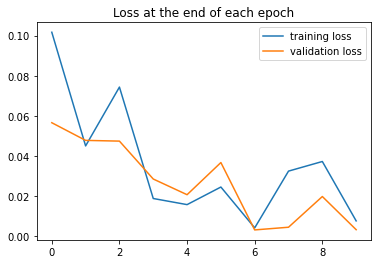

In [18]:
mch.visualiziseTrainResults(train_losses=train_loss,test_losses=val_loss)

In [19]:
# mch.saveModel(model=model,filename="RiceModelWeights")